In [1]:
import json
import pathlib
all_listings = json.loads(pathlib.Path('./all_listings.json').read_text())

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(all_listings)
#format table
df.date_listed = pd.to_datetime(df.date_listed)
CITY_TRANSLATIONS = {'קרית אונו': 'Kiryat Ono', 'חולון': 'Holon', 'תל אביב יפו': 'Tel Aviv Yafo', 'פתח תקווה': 'Petah Tikva',
                    'רמת גן': 'Ramat Gan', 'בת ים': 'Bat Yam', 'ראשון לציון': 'Rishon LeTsiyon', 'לוד': 'Lod', 'רמלה': 'Ramle',
                    'בני ברק': 'Bnei Brak', 'ראש העין': 'Rosh HaAyin', 'מודיעין מכבים רעות': 'Modiin Maccabim Reut',
                    'גבעתיים': 'Givataim', 'אור יהודה': 'Or Yehuda', 'באר יעקב': 'Be\'er Ya\'akov', 'אלעד': 'Elad',
                    'יהוד מונוסון': 'Yehud Monosson', 'גבעת שמואל': 'Giv\'at Shmuel', 'גני תקווה': 'Ganei Tikva',
                    'אזור': 'Azor', 'בית דגן': 'Beit Dagan', 'שוהם': 'Shoham', 'הרצליה': 'Herzliya', 'הוד השרון': 'Hod HaSharon',
                    'נתניה': 'Netanya', 'כפר סבא': 'Kfar Saba', 'רעננה': 'Ra\'anana', 'כפר יונה': 'Kfar Yona',
                    'צור יצחק': 'Tsur Itshak', 'תל מונד': 'Tel Mond', 'קדימה צורן': 'Kadima Tsoran',
                    'רמת השרון': 'Ramat HaSharon', 'טייבה': 'Taibe', 'צור משה': 'Tsur Moshe'}
CITIES_BLACKLIST = {'Ramle', 'Lod', 'Elad', 'Netanya'}
# CITIES_BLACKLIST = {}
MIN_AMOUNT_OF_LISTINGS_IN_CITY = 9

df.city = [CITY_TRANSLATIONS[city] for city in df.city]
# drop erroneos extreme rows to clean data set
df = df[(df.area < df.area.mean() * 5) & (df.area > df.area.mean() / 5)]
df = df[df.date_listed > (pd.Timestamp.today() - pd.Timedelta(16, unit='W'))]
listing_count_by_city = df.city.value_counts()
# print(listing_count_by_city)
cities_to_ignore = CITIES_BLACKLIST | set(listing_count_by_city.loc[
    lambda amount_of_listings: amount_of_listings < MIN_AMOUNT_OF_LISTINGS_IN_CITY].index)
df = df[~df.city.isin(cities_to_ignore)]
df.describe()

,floor,rooms,area,price
count,4477.000000,4477.000000,4477.000000,4.477000e+03
mean,2.996873,3.367434,89.731963,2.402411e+06
std,2.823286,0.945165,31.394981,4.081506e+05
min,-1.000000,0.000000,22.000000,1.000000e+06
25%,1.000000,3.000000,70.000000,2.090000e+06
50%,2.000000,3.000000,88.000000,2.450000e+06
75%,4.000000,4.000000,105.000000,2.750000e+06
max,58.000000,8.000000,452.000000,3.000000e+06


Text(0.5, 1.0, 'Distribution of the Area of Listings')

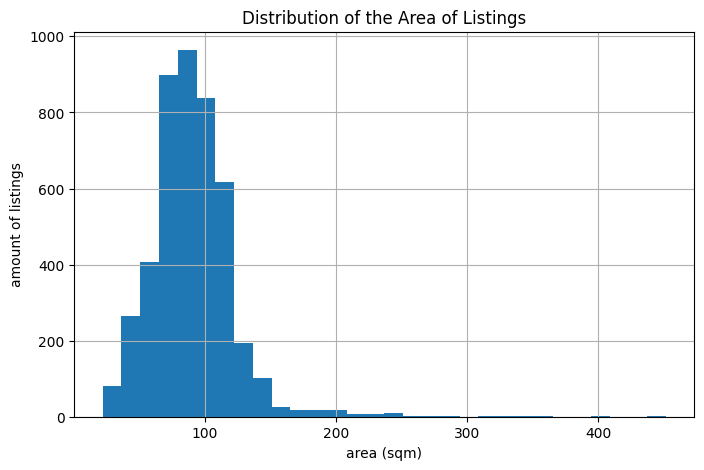

In [3]:
plot = df.area.hist(bins=30, figsize=(8, 5))
plot.set_xlabel('area (sqm)')
plot.set_ylabel('amount of listings')
plot.set_title('Distribution of the Area of Listings')

Text(0.5, 1.0, 'Amount of Listings, and the Price per Square Meter, for each City')

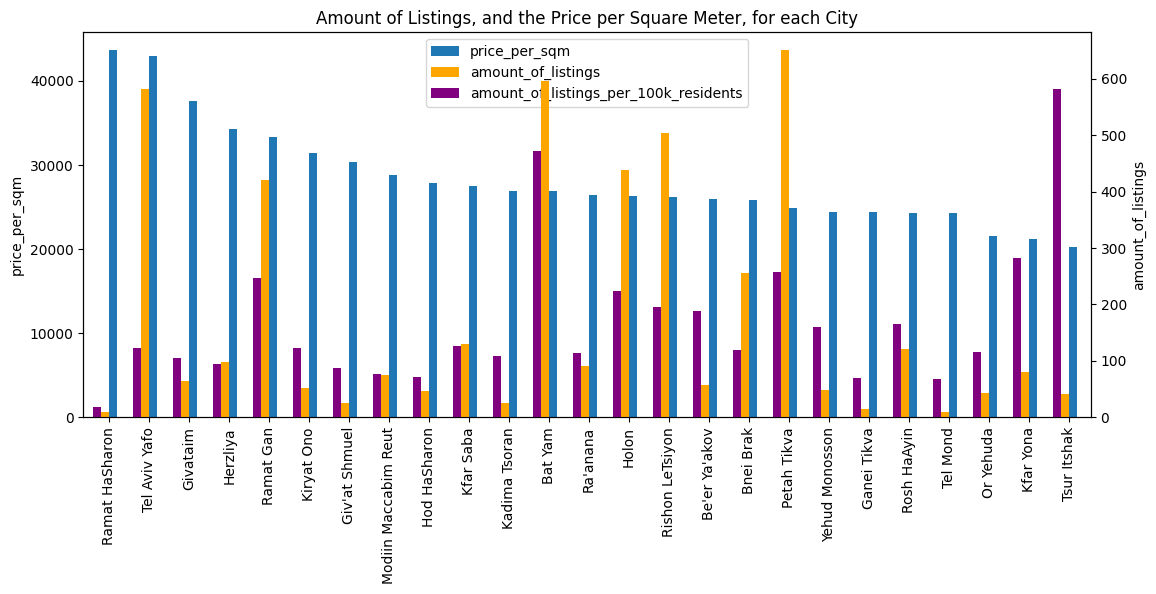

In [40]:
# create df
CITY_POPULATIONS = {'Ramat HaSharon': 48001, 'Tel Aviv Yafo': 470563, 'Givataim': 61346, 'Herzliya': 104083,
                    'Ramat Gan': 170221, 'Kiryat Ono': 42050, 'Giv\'at Shmuel': 28510, 'Modiin Maccabim Reut': 97604,
                    'Hod HaSharon': 65601, 'Kfar Saba': 101823, 'Kadima Tsoran': 23000, 'Bat Yam': 126265,
                    'Ra\'anana': 79010, 'Holon': 196734, 'Rishon LeTsiyon': 257391, 'Be\'er Ya\'akov': 30301,
                    'Bnei Brak': 214292, 'Petah Tikva': 252916, 'Yehud Monosson': 30814, 'Ganei Tikva': 21471,
                    'Rosh HaAyin': 72569, 'Tel Mond': 14517, 'Or Yehuda': 37055, 'Kfar Yona': 28328, 'Tsur Itshak': 7048}
amount_of_listings = df.city.value_counts()
amount_of_listings.name = 'amount_of_listings'
df['price_per_sqm'] = df.price / df.area
prices_per_sqm = df.groupby('city').mean(numeric_only=True)['price_per_sqm'].sort_values(ascending=False).astype(int)
cities_df = pd.merge(prices_per_sqm, amount_of_listings, left_index=True, right_index=True)
cities_df = cities_df.assign(city_population=CITY_POPULATIONS)
cities_df['amount_of_listings_per_100k_residents'] = ((cities_df.amount_of_listings / cities_df.city_population) * 100000).astype(int)

# plotting
fig, ax = plt.subplots()
ax2 = ax.twinx()
cities_df.price_per_sqm.plot.bar(ax=ax, width=0.2, position=0)
cities_df.amount_of_listings.plot.bar(ax=ax2, width=0.2, color='orange', position=1)
cities_df.amount_of_listings_per_100k_residents.plot.bar(ax=ax2, width=0.2, color='purple', position=2)
ax.set_ylabel(prices_per_sqm.name)
ax2.set_ylabel(amount_of_listings.name)
ax.set_xlim(right=(ax.get_xlim()[1] + 0.25))
ax2.set_xlim(right=(ax2.get_xlim()[1] + 0.25))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper center')
fig.set_size_inches(13, 5)
ax.set_title('Amount of Listings, and the Price per Square Meter, for each City')

In [7]:

df1.sort_values(['amount_of_listings'], ascending=False)
df1.reset_index(inplace=True, names='city')
df1.sort_values(['amount_of_listings_per_capita'], ascending=False)

,city,amount_of_listings,city_population,amount_of_listings_per_capita
19,Tsur Itshak,41,7048,581.725312
1,Bat Yam,596,126265,472.023126
11,Kfar Yona,80,28328,282.406100
0,Petah Tikva,650,252916,257.002325
5,Ramat Gan,421,170221,247.325536
4,Holon,439,196734,223.143941
3,Rishon LeTsiyon,503,257391,195.422528
14,Be'er Ya'akov,57,30301,188.112604
8,Rosh HaAyin,121,72569,166.737863
16,Yehud Monosson,49,30814,159.018628


In [6]:
# Ideas for graphs:
# add listings per capita to cities graph
# stats of the median apartment properties per city per price point for top 5-10 cities
# gather rent listings and match apartemnts with same city & area (in buckets of 10-20) to find price/rent ratios